In [1]:
from subprocess import Popen, PIPE

import numpy as np
import pandas as pd
import xarray as xr

from glob import glob
from os.path import isfile
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'

site_list = np.array([f.split('/')[-1].split('_')[0] for f in glob(obdir + '*.csv') if 'AUTO' not in f])
site_list = np.unique(site_list[np.argsort(site_list)])

# Dictionary builder (print blank entry)
for s in ['SITE']:
    print("'%s':{\n\t'header':[],\n\t'units':[],\n\t'tzinfo':None,\n\t'tfmt':['', '']\n\t'tfix':None,\n\t'tshift':None,\n\t'auto_site':''\n},"%s)

'SITE':{
	'header':[],
	'units':[],
	'tzinfo':None,
	'tfmt':['', '']
	'tfix':None,
	'tshift':None,
	'auto_site':''
},


In [3]:
# some standards... 
# precip/snow/depth should be swe12/snow12/depth12 or swe24/snow24/depth24 (or other interval)
# temperature over an interval gt 1h should be noted as tmax/tavg/tmin (use t for instantaneous only)
# manual does not need an identifier, auto should be swe12_auto/snow12_auto etc
# tzinfo should be in STANDARD time, we can adjust for daylight time later if needed
# tfmt should be split according to date columns - one column, one item; two columns, two items, etc
# use tfix to set a fixed observation hour (local time HHMM)

file_info = {
    'ALTA':{
        'header':['LOCATION','DATE','PRCP','SNOW','SNWD','TMAX','TMIN','TOBS'],
        'rename':[None, 'date', 'swe24', 'snow24', 'depth24', 'tsfc_max', 'tsfc_min', 'tsfc'],
        'units':[None, None, 'in', 'in', 'in', 'degF', 'degF', 'degF'],
        'tzinfo':-7,
        'tfmt':'%m/%d/%Y',
        'tfix':18,
        'tshift':None,
        'auto_site':'CLN',
    },
    'AGD':{
        'header':['Location','DateMST','TimeMST','MaxT','MinT','12HrSnow','24HrSnow','12HrWater','24HrWater'],
        'rename':[None, 'date', 'time', 'tsfc_max', 'tsfc_min', 'snow12', 'snow24', 'swe12', 'swe24'],
        'units':[None, None, None, 'degF', 'degF', 'in', 'in', 'in', 'in'],
        'tzinfo':-7,
        'tfmt':['%m/%d/%y', '%H:%M:%S'],
        'tfix':None,
        'tshift':None,
        'auto_site':'CLN',
    },
}

#### Import the manual observations

In [4]:
site = 'ALTA'
finfo = file_info[site]

f = glob(obdir + '%s*.csv'%site)[0]

data_raw = pd.read_csv(f, low_memory=False)

for old, new, unit in zip(finfo['header'], finfo['rename'], finfo['units']):
    if new is not None:
        new = new+'_%s'%unit if unit is not None else new
        data_raw = data_raw.rename(columns={old:new})
        
        if unit is not None:
            data_raw[new] = data_raw[new].astype(np.float32)
            
    else:
        data_raw = data_raw.drop(columns=old)

if finfo['tfix'] is not None:
    data_raw['datetime'] = [datetime.strptime(t, finfo['tfmt'])+timedelta(hours=finfo['tfix']) for t in data_raw['date']]
    
elif len(finfo['tfmt']) == 2:
    tfmt = ' '.join(finfo['tfmt'])
    data_raw['datetime'] = [datetime.strptime(' '.join(dt), tfmt) for dt in zip(data_raw['date'], data_raw['time'])]
    data_raw['datetime'] = [d+timedelta(minutes=60-d.minute) 
                            if d.minute > 30 else d-timedelta(minutes=d.minute) for d in data_raw['datetime']]
    
elif len(finfo['tfmt']) == 1:
    pass
    
# If we are going to attempt to assign tzinfo and parse ST vs DT, do it here and now
# For now this is timezone-naive
data_raw['datetime_utc'] = data_raw['datetime'] + timedelta(hours=finfo['tzinfo'])

# Clean things up
data_raw = data_raw.set_index('datetime_utc')
data_raw = data_raw.sort_index()
data_raw = data_raw.drop(columns=[k for k in data_raw.keys() if (('date' in k)|('time' in k))])
    
in_mm = 25.4
cm_mm = 1/10 
m_mm = 1/1000

for k in data_raw.keys():    
    if k[-3:] == '_in':
        data_raw[k] *= in_mm
        data_raw = data_raw.rename(columns={k:k.replace('_in', '_mm')}).round(2)
    elif k[-3:] == '_cm':
        data_raw[k] *= cm_mm
        data_raw = data_raw.rename(columns={k:k.replace('_cm', '_mm')}).round(2)
    elif k[-2:] == '_m':
        data_raw[k] *= m_mm
        data_raw = data_raw.rename(columns={k:k.replace('_m', '_mm')}).round(2)
    
    elif k[-5:] == '_degF':
        data_raw[k] = (data_raw[k] - 32) * (5 / 9)
        data_raw = data_raw.rename(columns={k:k.replace('_degF', '_degC')}).round(2)
        
intervals = [k.split('_')[0].replace('snow', '') for k in data_raw.keys() if ('snow' in k)]
for i in intervals:
    data_raw.insert(0, 'slr'+i, data_raw['snow%s_mm'%i]/data_raw['swe%s_mm'%i])
    data_raw['slr'+i][np.isinf(data_raw['slr'+i])] = np.nan

# print(data_raw.shape)
# data_raw = data_raw.drop_duplicates()
# print(data_raw.shape)

data_raw

,slr24,swe24_mm,snow24_mm,depth24_mm,tsfc_max_degC,tsfc_min_degC,tsfc_degC
datetime_utc,,,,,,,
1944-11-21 11:00:00,NaN,0.00,NaN,508.0,11.11,-12.78,-6.67
1944-11-22 11:00:00,NaN,0.00,NaN,482.6,8.89,-7.22,-1.67
1944-11-23 11:00:00,NaN,0.00,NaN,482.6,13.33,-4.44,4.44
1944-11-24 11:00:00,7.316371,20.83,152.4,635.0,11.11,-10.00,-8.89
1944-11-25 11:00:00,183.815789,1.52,279.4,914.4,-3.33,-11.67,-10.00
1944-11-26 11:00:00,NaN,0.00,NaN,914.4,-1.67,-13.89,-8.89
1944-11-27 11:00:00,NaN,0.00,NaN,863.6,2.78,-10.56,-6.67
1944-11-28 11:00:00,12.000000,6.35,76.2,939.8,6.67,-12.22,-11.11
1944-11-29 11:00:00,NaN,0.00,NaN,889.0,6.67,-11.67,-1.11


#### Use the automated data as a baseline/sanity check
Data is obtained from mesowest API - May use the timeseries or precipitation service<br>
https://developers.synopticdata.com/mesonet/v2/stations/timeseries/<br>
https://developers.synopticdata.com/mesonet/v2/stations/precipitation/<br>
To save long records, will need to access as csv format not json


#### Isolate precipitating (snow) periods

#### Resample the hourlies to match the 12h

In [5]:
data_all = data_raw

#### Ensure that the data isn't mislabeled by plotting/visualizing segments
These should be correct, but check that the beginning of period isn't labeled instead of end, etc.<br>
A time-shift correction can be applied if needed. Keep in mind the automated data will likely <br>
underreport vs the manual observations so consider the timing more than event size

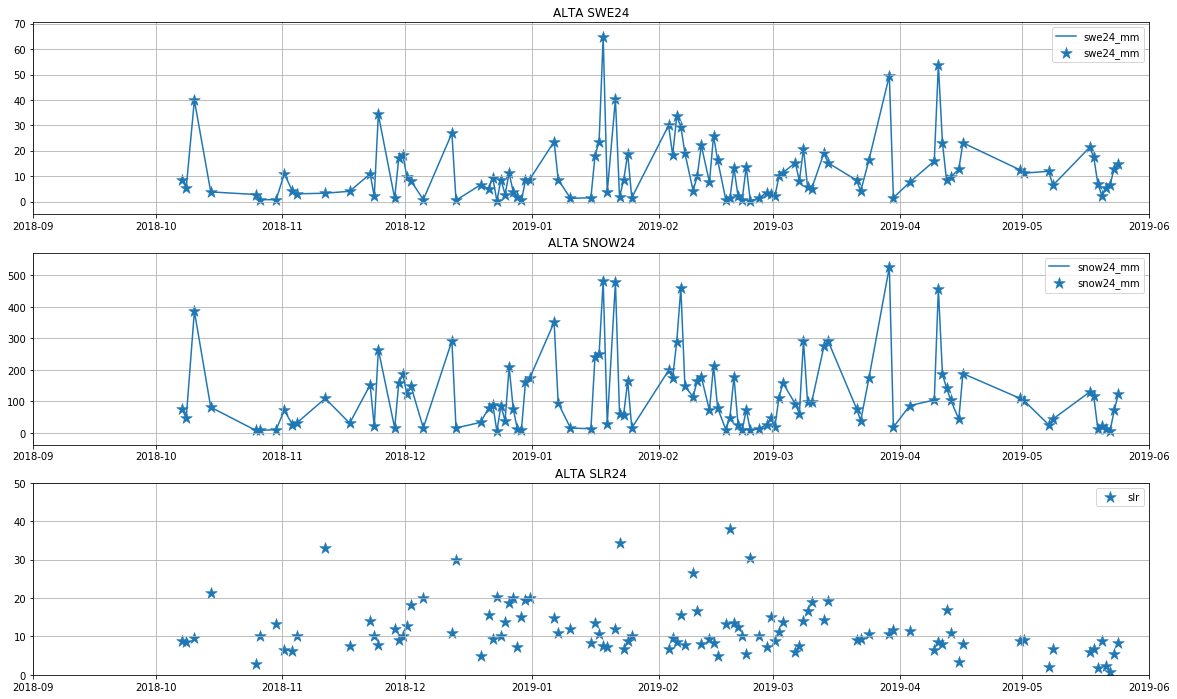

In [6]:
time_shift = finfo['tshift'] if finfo['tshift'] is not None else 0

for i in [intervals[-1]]:
    snowkey = 'snow%s_mm'%i
    swekey = 'swe%s_mm'%i

    fig, axs = plt.subplots(3, 1, figsize=(20, 12), facecolor='w')
    
    d0 = datetime(2018, 9, 1, 0, 0)
    d1 = datetime(2019, 6, 1, 0, 0)
    mask = ((data_all.index > d0) & (data_all.index <= d1) & 
           (data_all[swekey] > 0.) & (data_all[snowkey] > 0.))
    
    axs[0].set_title('%s SWE%s'%(site, i))

    axs[0].plot(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, swekey], color='C0')
    axs[0].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, swekey], 
                   marker='*', s=150, linewidth=0.5, color='C0')

    # axs[0].plot(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], color='C1')
    # axs[0].scatter(data_all.loc[mask].index, data_all.loc[mask, 'swe_auto_mm'], 
    #                marker='*', s=150, linewidth=0.5, color='C1')

    axs[1].set_title('%s SNOW%s'%(site, i))

    axs[1].plot(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, snowkey], color='C0')
    axs[1].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, snowkey], 
                   marker='*', s=150, linewidth=0.5, color='C0')

    # axs[1].plot(data_all.loc[mask].index, data_all.loc[mask, 'snow_auto_mm'], color='C1')
    # axs[1].scatter(data_all.loc[mask].index, data_all.loc[mask, 'snow_auto_mm'], 
    #                marker='*', s=150, linewidth=0.5, color='C1')

    axs[2].set_title('%s SLR%s'%(site, i))

    axs[2].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, snowkey]/data_all.loc[mask, swekey], 
                   marker='*', s=150, linewidth=0.5, color='C0', label='slr')
    # axs[2].scatter(data_all.loc[mask].index + timedelta(hours=time_shift), data_all.loc[mask, 'snow_auto_mm']/data_all.loc[mask, 'swe_auto_mm'], 
    #                marker='*', s=150, linewidth=0.5, color='C1', label='slr_auto')

    axs[2].set_ylim([0, 50])

    for ax in axs:
        ax.set_xlim([d0, d1])
        ax.legend()
        ax.grid()

    plt.show()

#### Apply the time shift (if any) permanantly and save out (to netCDF or .pd?)

#### Save out the precip periods with the dataset (merge column)

In [7]:
if 'precip_periods' not in data_all.keys():
    data_all['precip_periods'] = np.full(data_all.shape[0], fill_value='[]')

In [8]:
data_save = data_all

In [9]:
data_save_file = f.split('/')[-1].replace('.csv', '.pd')
print('Saving %s'%data_save_file)

data_save.to_pickle(obdir + 'clean/' + data_save_file)

Saving ALTA_1944_2020.pd
